In [0]:
# import Libraries
from fastai import *
from fastai.text import *
from pathlib import Path
import pandas as pd
import numpy as np
import re
import string

In [0]:
#import Dataset

train_data = pd.read_csv('/content/gdrive/My Drive/train.csv')
test_data = pd.read_csv('/content/gdrive/My Drive/test.csv')

In [0]:
import torch
print("Cuda available" if torch.cuda.is_available() is True else "CPU")
print("PyTorch version: ", torch.__version__)

Cuda available
PyTorch version:  1.1.0


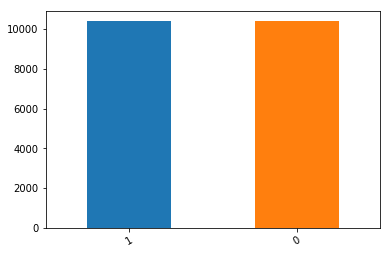

In [0]:
# Plot value counts for rach stance in the dataset
train_data['label'].value_counts().plot.bar(rot=30);

In [0]:
train_data.head()

,id,title,author,text,label
0,0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,1
1,1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,0
2,2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ...",1
3,3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...,1
4,4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \nAn Iranian woman has been sentenced to...,1


In [0]:
train_data['text'] = train_data['text'].str.replace("[^a-zA-Z]", " ")

In [0]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [0]:
from nltk.corpus import stopwords 
stop_words = stopwords.words('english')

In [0]:
# Lets Clean the Datasets
missing_rows = []
for i in range(len(train_data)):
  if train_data.loc[i, 'text'] != train_data.loc[i, 'text']:
    missing_rows.append(i)
train_data = train_data.drop(missing_rows).reset_index().drop(['index','id'],axis=1)

In [0]:
def textClean(text):
    """
    Get rid of the non-letter and non-number characters
    """
    text = re.sub(r"[^A-Za-z0-9^,!.\/'+-=]", " ", text)
    text = text.lower().split()
    stops = set(stopwords.words("english"))
    text = [w for w in text if not w in stops]
    text = " ".join(text)
    return (text)


def cleanup(text):
    text = textClean(text)
    text = text.translate(str.maketrans("", "", string.punctuation))
    return text

In [0]:
for i in range(len(train_data)):
        train_data.loc[i, 'text'] = cleanup(train_data.loc[i,'text'])

In [0]:
train = pd.concat([train_data['label'], train_data['text']], axis=1)
train.tail()

,label,text
20756,0,rapper unloaded black celebrities met donald t...
20757,0,green bay packers lost washington redskins wee...
20758,0,macy today grew union several great names amer...
20759,1,nato russia hold parallel exercises balkans pr...
20760,1,david swanson author activist journalist radio...


In [0]:
train.to_csv('/content/gdrive/My Drive/traindata.csv', index=False, header=False)

In [0]:
# Language model data
path = '/content'
data_lm = TextLMDataBunch.from_csv(path, 'trrain.csv', min_freq=1)

In [0]:
data_lm.save()

In [0]:

data_lm.show_batch()

idx,text
0,transforming life one night time harmony call bed also inspiring turbocharged national tour involves sleep fairs colleges educational takeover jetblue flight gave books answered questions want rekindle romance sleep said ms huffington lullaby voice soothing floral perfume central part life gateway dreams sleep gateway dreams bedroom mother ship one four vast apartment transformed years ago help designer steven gambrel minimalist loft said wanted something felt european achieve hired mr gambrel
1,passed year united nations educational scientific cultural organization unesco deny indisputable jewish nexus holy city april member body voted favor asinine wholly one sided resolution referred jewish holy sites jerusalem exclusively muslim names designated temple mount judaism holiest site muslim holy site worship add insult injury resolution also adopted wild conspiracy theories including claim israel planting jewish fake graves spaces muslim cemeteries unsurprisingly resolution submitted seven muslim nations passed wide
2,new model became available john meyer entrepreneur new york made reservation time flight newark los angeles worried would miss plane went called car game changer everything wants cool beautiful powerful said well environmentally friendly could bought prius said would looked like audi xxbos home world experts britain national security stake infiltrated eu experts britain national security stake infiltrated eu guy fawkes corruptio optimi pessima est london england high court decision
3,alleged retaliation comes considerable time plaintiff first complained discrimination approach hardly bulletproof trend downsides however goal root address actual discrimination whole point wrongdoing workplace want make sure employer understands corrects go future ms calvert said focus primarily retaliation getting effect extreme situation aggressively policing retaliation setting dauntingly high bar many types discrimination claims could odd effect making relatively easy workers confront employers giving employers little incentive change certain corrosive practices
4,stop u gymnastics done stop mad knowing said abuse many levels complete betrayal think sport young girls young girls wearing leotards prancing around legs flying place u gymnastics would educate gymnasts coaches parents sexual abuse knew larson said could saved others countless others u center safesport existed competing many victims come forward yet said know national team members olympians least u gymnastics united states olympic committee could mandated sexual abuse


In [0]:
learn = language_model_learner(data_lm, AWD_LSTM, drop_mult=0.1)

In [0]:
list(learn.model.children())

[AWD_LSTM(
   (encoder): Embedding(44208, 400, padding_idx=1)
   (encoder_dp): EmbeddingDropout(
     (emb): Embedding(44208, 400, padding_idx=1)
   )
   (rnns): ModuleList(
     (0): WeightDropout(
       (module): LSTM(400, 1150, batch_first=True)
     )
     (1): WeightDropout(
       (module): LSTM(1150, 1150, batch_first=True)
     )
     (2): WeightDropout(
       (module): LSTM(1150, 400, batch_first=True)
     )
   )
   (input_dp): RNNDropout()
   (hidden_dps): ModuleList(
     (0): RNNDropout()
     (1): RNNDropout()
     (2): RNNDropout()
   )
 ), LinearDecoder(
   (decoder): Linear(in_features=400, out_features=44208, bias=True)
   (output_dp): RNNDropout()
 )]

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


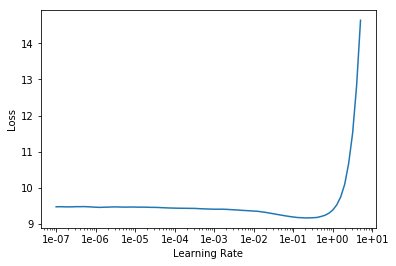

In [0]:
learn.lr_find(start_lr=1e-8, end_lr=1e2)
learn.recorder.plot()

In [0]:
learn = language_model_learner(data_lm, AWD_LSTM, drop_mult=0.5)
learn.fit_one_cycle(cyc_len=1, max_lr=1e-3, moms=(0.8, 0.7))

epoch,train_loss,valid_loss,accuracy,time
0,8.964356,8.255980,0.041397,00:55


In [0]:
#Train the learner object
learn.unfreeze()
learn.fit_one_cycle(cyc_len=7, max_lr=1e-3, moms=(0.8, 0.7))

epoch,train_loss,valid_loss,accuracy,time
0,8.288862,7.665881,0.053505,01:02
1,7.897895,7.433563,0.062343,01:03
2,7.534077,7.308970,0.068255,01:03
3,7.234313,7.240620,0.073407,01:03
4,6.976686,7.232811,0.077166,01:03
5,6.787736,7.230643,0.078445,01:03
6,6.698051,7.240894,0.078933,01:03


In [0]:
# Save the fine-tuned encoder
learn.save_encoder('ft_enc')

In [0]:
# Classifier model data
data_clas = TextClasDataBunch.from_csv(path, 'trrain.csv', vocab=data_lm.train_ds.vocab,
                                       min_freq=1, bs=32)
data_clas.save()

In [0]:
data_clas.show_batch()

text,target
xxbos polls rigged trump wildly xxunk surveys can not possibly correct michael television best place live united states prepare coming economic collapse may nd best place live united states get asked question time answer summed two words depends truth answer going different person us different goals different needs strong network family friends live right might want think twice moving hundreds thousands miles away great job live right might want hold,1
xxbos president putin speech valdai putin speech valdai jrl october president russia vladimir putin tarja heinz thabo colleagues ladies gentlemen great pleasure see want start thanking participants valdai international discussion club russia abroad constructive part work want thank distinguished guests readiness take part open discussion esteemed moderator wished good departure retirement wish time comes right approach thing retired yet leader big country fitting show restraint avoid displays excessive aggressiveness think,1
xxbos references debate started daniel blatman israeli historian head institute contemporary jewry hebrew university jerusalem penned op ed israeli daily haaretz stating ethnic cleansing exactly happened support blatman cited benny morris israeli historian blatman wrote determined arabs country encouraged leave expelled first stage war even arab nations armies invaded benny morris october aude cc sa prompted response morris wrote op ed titled israel conducted ethnic cleansing contends blatman distorts history,1
xxbos summer light fading gold near red square oliver stone maneuvered lobby bar moscow hotel last year walked past marble staircase grand piano table back group businessmen suits lingered nearby stone xxunk think move said producer xxunk xxunk led way another corner xxunk asked stone answer eyed older couple slurping soup kept moving moment later stone finally settled window comfortably beyond earshot patrons security precautions become routine ever since stone,0
xxbos list establishment republicans say voting hillary clinton staggering michael snyder august st would ever believed many big names republican party would publicly pledge vote hillary clinton election throughout primaries caucuses republican establishment expressed tremendous disdain donald trump unable derail march nomination reached general election biggest names gop actually taking unprecedented step crossing side publicly announcing support hillary clinton shows many individuals republicans name begin also demonstrates lengths elite willing,1


In [0]:
learn = text_classifier_learner(data_clas, AWD_LSTM, drop_mult=0.5)
learn.load_encoder('ft_enc')

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


epoch,train_loss,valid_loss,accuracy,time
0,0.446348,0.297840,0.875000,00:28


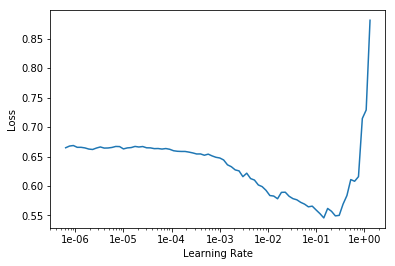

In [0]:
learn.lr_find()
learn.recorder.plot()
learn.fit_one_cycle(1, 2e-2, moms=(0.8,0.7))

In [0]:
learn.save('first')

learn.load('first')
learn.freeze_to(-2)
learn.fit_one_cycle(1, slice(1e-2/(2.6**4),1e-2), moms=(0.8,0.7))



epoch,train_loss,valid_loss,accuracy,time
0,0.387119,0.269713,0.877500,00:34


In [0]:
learn.save('third')

learn.load('third')
learn.unfreeze()
learn.fit_one_cycle(2, slice(1e-3/(2.6**4),1e-3), moms=(0.8,0.7))



epoch,train_loss,valid_loss,accuracy,time
0,0.298967,0.255579,0.892500,00:47
1,0.266743,0.246960,0.900000,01:04


In [0]:
n=[]
a=input("Input a news")
n.append(a)
print(n)
lk=str(learn.predict(n))
print(lk[0])




Input a newsxxbos references debate started daniel blatman israeli historian head institute contemporary jewry hebrew university jerusalem penned op ed israeli daily haaretz stating ethnic cleansing exactly happened support blatman cited benny morris israeli historian blatman wrote determined arabs country encouraged leave expelled first stage war even arab nations armies invaded benny morris october aude cc sa prompted response morris wrote op ed titled israel conducted ethnic cleansing contends blatman distorts history
['xxbos references debate started daniel blatman israeli historian head institute contemporary jewry hebrew university jerusalem penned op ed israeli daily haaretz stating ethnic cleansing exactly happened support blatman cited benny morris israeli historian blatman wrote determined arabs country encouraged leave expelled first stage war even arab nations armies invaded benny morris october aude cc sa prompted response morris wrote op ed titled israel conducted ethnic 

In [0]:
a=input("Input a news")
learn.predict(a)


Input a newsmystery surrounding third reich nazi germany still subject debate many observers believe nazi germany control adolf hitler possessed supernatural powers largely employed pseudo science period however also hold belief mere speculation without proven fact years researchers searched extensively answers mysterious activities associated nazi germany nazi germany invaded russia formerly ussr second world war june time german army progressed deep russian territory gaining ground close capital moscow russians could counter attack eventually driving nazis back nazi occupation russia nazis built secret military base around arctic code named schatzgraber treasure hunter reportedly instrumental war russia base primarily used tactical weather station planning strategic movements nazi troops warships submarines base also housed eminent nazi scientists conducted many experiments help progress german win war widely speculated time nazis used base contact aliens extraterrestrial beings cont

(Category 1, tensor(1), tensor([0.0108, 0.9892]))

In [0]:
# get predictions
preds, targets = learn.get_preds()
predictions = np.argmax(preds, axis=1)
pd.crosstab(predictions, targets)

col_0,0,1
row_0,,
0,193,19
1,21,167


In [0]:
test = pd.read_csv('/content/Un.csv')
test.tail()

,label,text
494,0,look renderings officially unveiled wednesday ...
495,1,cyber war trifle catastrophe ernest partridge ...
496,1,president putin speech valdai putin speech val...
497,0,even month ago mayor bill de blasio led boiste...
498,1,us drone strike afghanistan kills wounds sever...


In [0]:
test['news'] = test['text'].apply(lambda row: str(learn.predict(row)[0]))

In [0]:
# Write train to csv
test.to_csv('/content/demo2.csv', index=False, header=False)

In [0]:
test.tail()

,label,text,news
494,0,look renderings officially unveiled wednesday ...,0
495,1,cyber war trifle catastrophe ernest partridge ...,1
496,1,president putin speech valdai putin speech val...,0
497,0,even month ago mayor bill de blasio led boiste...,0
498,1,us drone strike afghanistan kills wounds sever...,1


In [0]:
import model_evaluation_utils as meu
meu.get_metrics(true_labels=test_labels, 
predicted_labels=predictions)

In [0]:
import csv

print("----------------------------------------------Fake News Detector----------------------------------------------------")
print(" ")
a=input("Input a News: ")
print( " ")
print("Processing----")
print(" " )
print("Processing Done!")
print( " ")

a=cleanup(a)
with open('/content/demo1.csv','w') as file:
  writer = csv.writer(file)
  writer.writerow(('text','Label'))
  writer.writerow((a,'nil'))
test = pd.read_csv('/content/demo1.csv')

test['news'] = test['text'].apply(lambda row: str(learn.predict(row)[0]))
test.tail()
target = test.loc[0,'news']
#print(target)
print(" " )
if(target == '1'):
  print("Beware... It's a Fake news!!")
else:
  print("No worries.. It is Real News")


----------------------------------------------Fake News Detector----------------------------------------------------
 
Input a News: wednesday donald trump press conference trump tower new york city nbc meet press moderator chuck todd expressed exasperation normalcy called circus surrounding trump event struck big picture wise normal circus us todd said circus never seen transition like saw today press conference gets interrupted lawyer lawyer half legal talk half political spin never seen using lawyer say make america great way going play constitutional lawyer think clearly constitutional lawyer told us better accept money made exception struck normal crazy looked us today crazy scene norm donald trump fact comfortable say political show donald trump want press conferences made press look disjointed unorganized stuff people know performance supporters people later segment todd decried saw elements within intelligence community odds one another called story put buzzfeed night earlier s